# Analysis Demonstration

### (things to talk about: how we ran analysis and gathered data, problems we ran into and how to solve them, how our functions could be used, things that surprised us, interesting conclusions, etc)

## Import Functions

In [1]:
# Packages
import pandas as pd
import numpy as np
import requests
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import math
import seaborn as sns
from collections import Counter
import scipy.stats as stats

# Our Functions
from scrape_data import scrape_imdb, scrape_rotten_tomatoes, get_html_text
from clean_data import clean_imdb, clean_rotten_tomatoes
from analysis_functions import list_averages, year_averages_plot



## Use Our Functions to Scrape and Clean Data
Our functions allow you to scrape data from imdb and rotten tomatoes lists of movies. The two lists we are using for our data are https://editorial.rottentomatoes.com/guide/disney-100-essential-movies/ and https://www.imdb.com/list/ls089035876/?sort=release_date,desc&st_dt=&mode=detail&page=1 which goes on to have five pages of disney movies. After scraping we create a csv file of the raw data which we then pass to our cleaning functions. The raw data as well as the final cleaned datasets are included in the data folder.

In [3]:
# Scrape from Rotten Tomatoes

webpage = "https://editorial.rottentomatoes.com/guide/disney-100-essential-movies/"
rotten_tomatoes = scrape_rotten_tomatoes(webpage)
rotten_tomatoes.to_csv('data/rotten_tomatoes_raw.csv', index = False)

In [3]:
# Scrape from IMDB

webpages = ["https://www.imdb.com/list/ls089035876/?sort=release_date,desc&st_dt=&mode=detail&page=1", 
            "https://www.imdb.com/list/ls089035876/?sort=release_date,desc&st_dt=&mode=detail&page=2",
            "https://www.imdb.com/list/ls089035876/?sort=release_date,desc&st_dt=&mode=detail&page=3", 
            "https://www.imdb.com/list/ls089035876/?sort=release_date,desc&st_dt=&mode=detail&page=4",
            "https://www.imdb.com/list/ls089035876/?sort=release_date,desc&st_dt=&mode=detail&page=5"]

imdb = pd.DataFrame()
for webpage in webpages:
    imdb = pd.concat([imdb, scrape_imdb(webpage)])

imdb.to_csv('data/imdb_raw.csv', index = False)

In [4]:
# Clean Rotten Tomatoes Dataframe

rotten_tomatoes = pd.read_csv('data/rotten_tomatoes_raw.csv')

rotten_tomatoes = clean_rotten_tomatoes(rotten_tomatoes)

rotten_tomatoes.to_csv('data/rotten_tomatoes.csv', index = False)

In [5]:
# Clean IMDB Dataframe

imdb = pd.read_csv('data/imdb_raw.csv')

# Drop 19 since it has no reviews or data aside from name
imdb = imdb.drop(19, axis='index')

# Drop 170 since it is a DVD containing episodes from different shows and not a movie
imdb = imdb.drop(170, axis='index')

imdb = clean_imdb(imdb)

imdb.to_csv('data/imdb.csv', index = False)

## Comparisons
We can then merge the two datasets to run comparisons.

In [60]:
merged = rotten_tomatoes.merge(imdb, how= 'inner', on = ['title', 'year'])
merged = merged.rename(columns={'score_y': 'imdb_score', 'comparison_score': 'rotten_tomatoes_score'})
merged.to_csv('data/merged.csv', index = False)

In [6]:
print("IMDB Score: ")
print(merged.imdb_score.mean())
print("Rotten Tomatoes Score: ")
print(merged.rotten_tomatoes_score.mean())

IMDB Score: 
7.332258064516129
Rotten Tomatoes Score: 
8.375268817204303


Below we utilize our list_averages function to get the average score for each director included in the directors column. Here we look at the top 20 directors.

In [8]:
item_count = imdb['director'].apply(lambda x: Counter(x))
top_directors = pd.DataFrame(sum(item_count, Counter()).most_common(20))


director_scores = list_averages(imdb, imdb['director'], imdb['score'])
top_scores = director_scores[director_scores[0].isin(list(top_directors[0]))]

top_directors.merge(top_scores, 'outer', on = [0])

,0,1_x,1_y
0,Robert Stevenson,18,6.4889
1,Norman Tokar,14,6.3571
2,Vincent McEveety,13,5.7692
3,Hamilton Luske,12,6.9750
4,James Algar,11,7.0364
5,Clyde Geronimi,11,6.9364
6,Jack Kinney,10,6.7900
7,Wilfred Jackson,9,7.2556
8,Ron Clements,7,7.4143
9,John Musker,7,7.4143


We use the same function to compute ratings for each genre. And then compare the genre ratings between imdb and rotten tomatoes.

In [73]:
genre_ratings = list_averages(imdb, imdb['genre'], imdb['score'])
genre_ratings.sort_values(by = 1)

,0,1
13,Crime,5.7250
15,Music,5.7556
14,Western,5.9444
20,Horror,6.1000
2,Comedy,6.1597
5,Family,6.1742
18,Romance,6.2125
6,Fantasy,6.3684
7,Drama,6.3986
21,War,6.4000


In [11]:
genre_ratings2 = list_averages(merged, merged['genre'], merged['imdb_score'])
genre_ratings2.sort_values(by = 1)

,0,1
11,Sci-Fi,6.7000
9,Mystery,6.9000
10,History,6.9000
4,Family,7.0694
6,Fantasy,7.1167
12,Romance,7.2000
5,Drama,7.2148
8,Sport,7.2750
2,Adventure,7.3500
1,Action,7.3727


In [12]:
genre_ratings3 = list_averages(merged, merged['genre'], merged['rotten_tomatoes_score'])
genre_ratings3[1] = genre_ratings3[1].astype(float)
genre_ratings3.sort_values(by = 1)

,0,1
10,History,3.9000
9,Mystery,4.6000
11,Sci-Fi,7.3000
6,Fantasy,7.8750
5,Drama,7.9111
7,Biography,7.9200
1,Action,7.9909
4,Family,8.0028
8,Sport,8.0500
2,Adventure,8.4583


Continuing our comparisons, we can look at the average score for rotten tomatoes and for IMDB.

Here is the score by decade for IMDB.

In [59]:
merged.groupby(merged['decade']).imdb_score.mean()

decade
1930    7.600000
1940    7.425000
1950    7.257143
1960    7.366667
1970    7.050000
1980    6.983333
1990    7.330000
2000    7.440000
2010    7.336364
2020    7.566667
Name: score_y, dtype: float64

And here is the same for Rotten Tomatoes.

In [58]:
merged.groupby(merged['decade']).rotten_tomatoes_score.mean()

decade
1930    9.700000
1940    9.525000
1950    9.014286
1960    8.500000
1970    7.750000
1980    7.916667
1990    7.970000
2000    8.520000
2010    8.231818
2020    9.200000
Name: comparison_score, dtype: float64

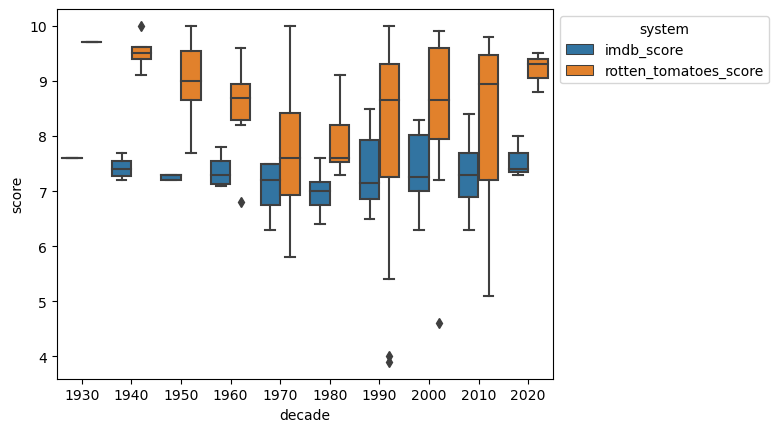

In [62]:
df = merged[['decade', 'imdb_score', 'rotten_tomatoes_score']]

df = pd.melt(df, id_vars=['decade'], value_vars=['imdb_score', 'rotten_tomatoes_score'], 
                   var_name='system', value_name='score')

ax = sns.boxplot(x='decade', y = 'score', data=df, hue='system')
sns.move_legend(ax, loc = "upper left", bbox_to_anchor=(1, 1))

And finally a graphical comparison.

Text(0.5, 1.0, '')

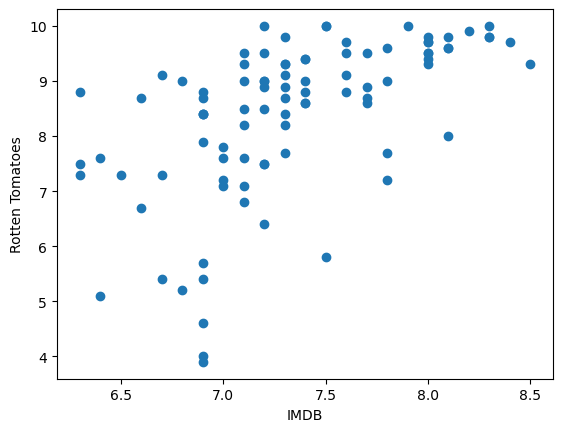

In [15]:
plt.scatter(merged.score_y, merged.comparison_score) 
plt.xlabel('IMDB')
plt.ylabel('Rotten Tomatoes')
plt.title('')

Another object of interest is the scores by movie rating.

<Axes: xlabel='rating', ylabel='score'>

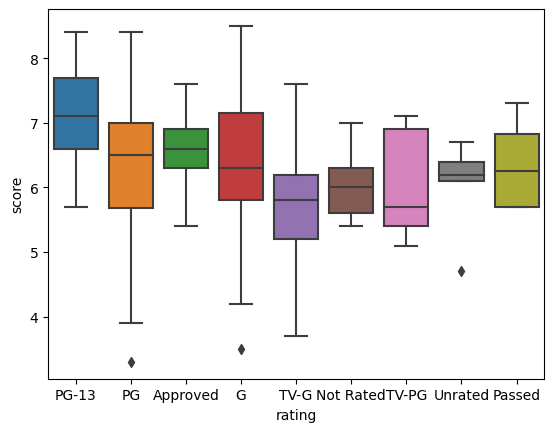

In [19]:
imdb.groupby(imdb['rating']).score.mean()
sns.boxplot(x='rating', y='score', data=imdb)

## Trends Over Time

We can also look at trends over the years in the following graphs.

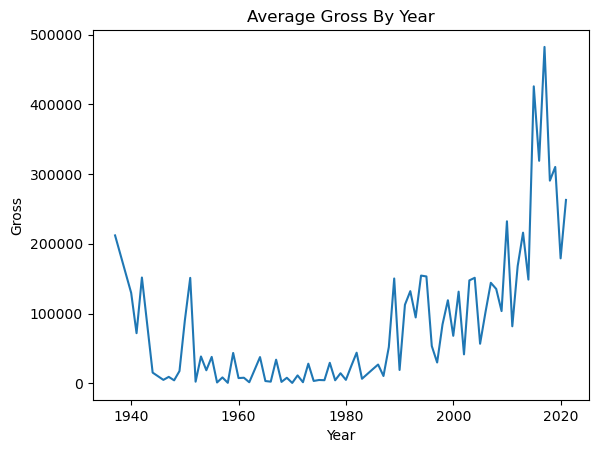

In [7]:
year_averages_plot(imdb, 'year', 'gross')

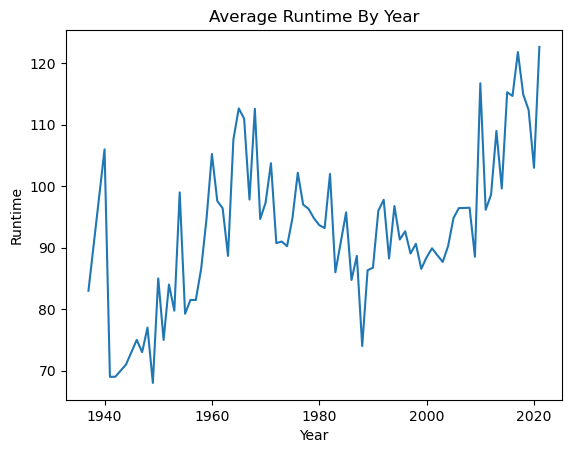

In [8]:
year_averages_plot(imdb, 'year', 'runtime')

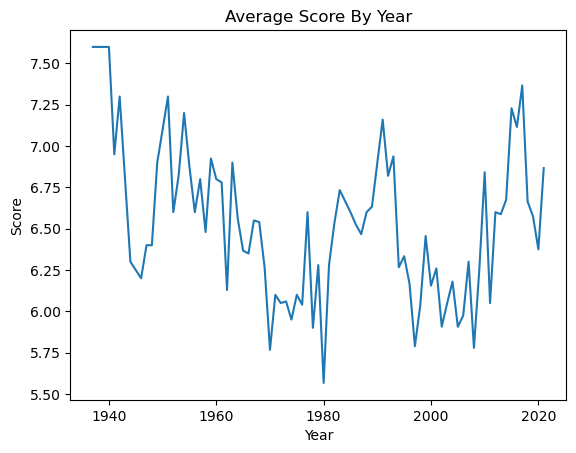

In [9]:
year_averages_plot(imdb, 'year', 'score')

## Further Comparisons
And finally the complete pairplot.

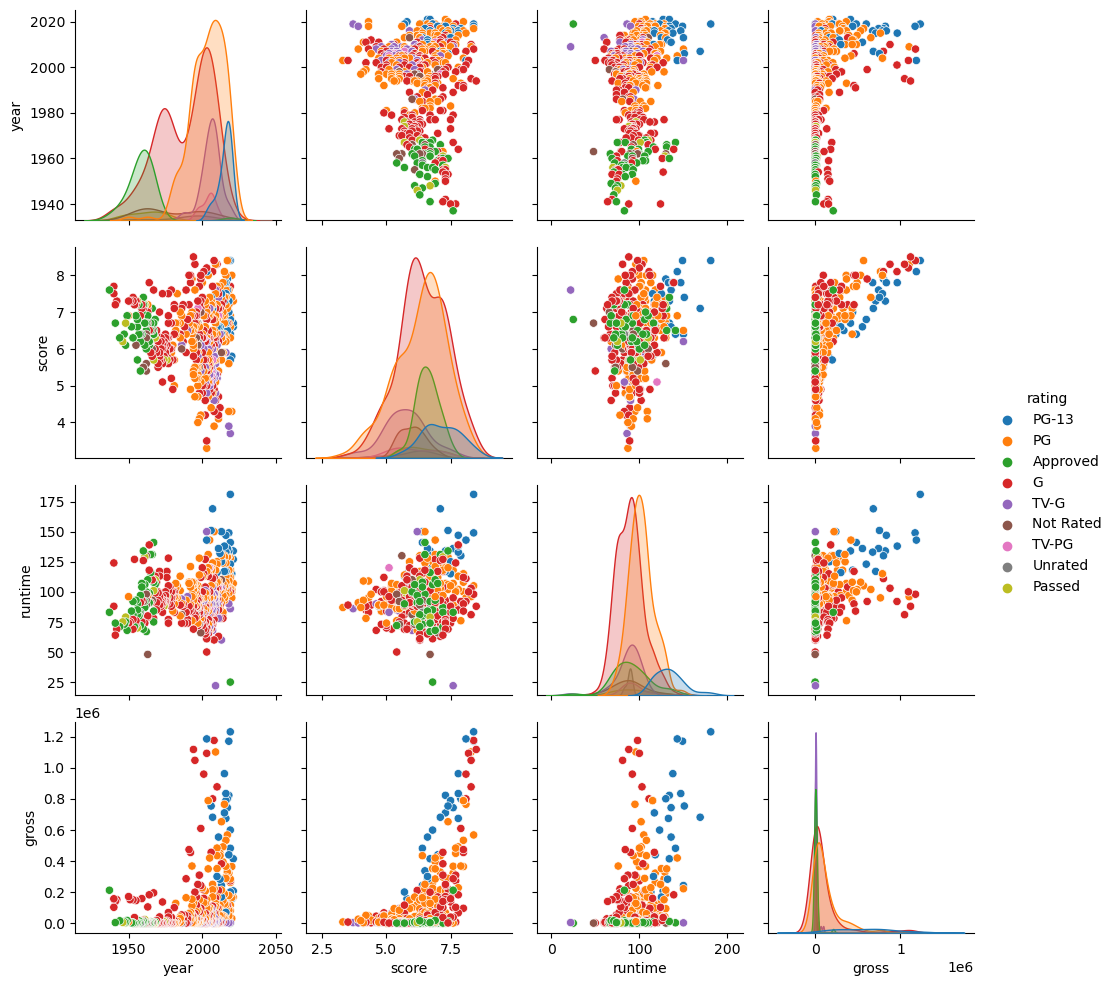

In [10]:
sns.pairplot(imdb[['year', 'score', 'runtime', 'gross', 'rating']], hue = 'rating')

We can also run a hypothesis test on whether the scores for IMDB and Rotten Tomatoes are the same, from which we get a value of 4e-10, which is practically 0, so we reject the null hypothesis that they are the same.

In [63]:
stats.ttest_ind(a=merged['imdb_score'], b=merged['rotten_tomatoes_score'], equal_var=True)

TtestResult(statistic=-6.59972177742585, pvalue=4.2624179743929416e-10, df=184.0)